In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits as fits
import healpy as hp
import pysm 
from pysm.nominal import models
from pysm.common import convert_units
import camb
from camb import model, initialpower
import scipy.optimize as opt
from numpy import linalg as LA

import utils

from utils import bin_l as bin_l
plt.rcParams['figure.figsize'] = (10.0, 8.0)

# functions

In [105]:

def plot_ps(cls, _nside):
#     plt.figure(figsize = (10,8));
    
    if len(cls.shape) == 1:
        _ell = np.arange(len(cls)); _ell2 = _ell[2:];
        plt.loglog(_ell2, _ell2*(_ell2+1)/2/np.pi*cls[2:], 'k-', label = 'TT');
        
    else:
        _ell = np.arange(len(cls[0])); _ell2 = _ell[2:];
        plt.loglog(_ell2, _ell2*(_ell2+1)/2/np.pi*cls[1][2:],label = 'EE');
        plt.loglog(_ell2, _ell2*(_ell2+1)/2/np.pi*cls[2][2:],label = 'BB');
    
    plt.legend(fontsize = 20);

# Public area

In [79]:
Nf = 3; nside = 512; lmax = 1000; Q = 50

In [80]:
Ell = utils.get_ell(lmax, Q)
el2 = utils.l2(Ell)

In [75]:
ali_ma = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits'), nside_out = 512)
def Mask(maps): 
    maps_ma = hp.ma(maps)
    maps_ma.mask = np.logical_not(ali_ma)
    return maps_ma

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [74]:
# def Mask(maps): 
    
#     maps_ma = np.zeros_like(maps)
    
#     if len(maps.shape) == 1:
#         _index = np.arange(len(maps));
#         maps_ma[_index[ali_ma == 0]] = maps[_index[ali_ma == 0]]
        
#     else:
#         _index = np.arange(len(maps[0]))
#         for _i in range(3):
#             maps_ma[_i][_index[ali_ma == 0]] = maps[_i][_index[ali_ma == 0]]

#     return maps_ma

(3, 3, 3145728)

In [76]:
total_map = Mask(np.load('/fnx/jianyao/ancillary_data/total_map/total_map_deconv_unmasked_IQU_000.npy'))

In [17]:
cl_clean_95 = np.load('/fnx/jianyao/cmb_0.05_realizations/cl_clean_95GHz_mean_std.npy')
#shape(4,50)
## mean for E and B, std for E and B;

# SEVEM

In [50]:
fun_std = lambda x,i,s :np.std(total_map[i,s] - x[0]*da1 - x[1]*da2)

In [151]:
methods = ['Powell', 'Nelder-Mead','CG']
# CG 1'17''
# Powell 23.3''
# Nelder-Mead 46.5''
cmb_clean = np.zeros((Nf, 3, 12*nside**2))

for i in range(2,3):
    
    for s in range(1,2): ### Stokes parameter
        
        da1 = total_map[1,s] - total_map[0,s]
        da2 = total_map[2,s] - total_map[1,s]
        
        results = opt.minimize(fun_std, (0, 0), args = (i,s), method = methods[0]) # CG 
        
        cmb_clean[i, s] = total_map[i,s] - results['x'][0]*da1 - results['x'][1]*da2

In [152]:
results

   direc: array([[ 0.00000000e+00,  1.00000000e+00],
       [-2.30231853e-02,  2.76233128e-04]])
     fun: 1.9890767762058663
 message: 'Optimization terminated successfully.'
    nfev: 78
     nit: 3
  status: 0
 success: True
       x: array([0.12515359, 1.02642564])

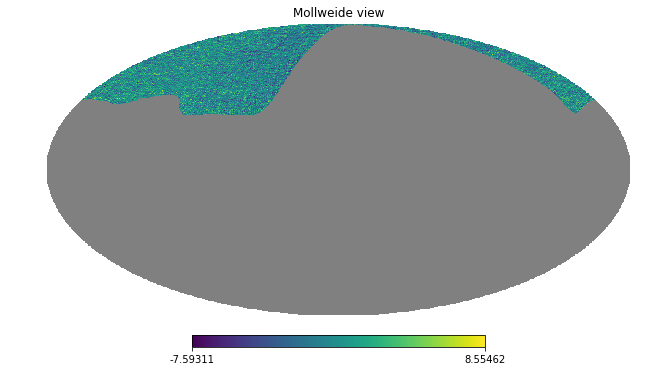

In [153]:
hp.mollview(Mask(cmb_clean[2, 1]))

In [149]:
results

   direc: array([[ 0.00000000e+00,  1.00000000e+00],
       [-7.20060138e-04,  1.09714425e-05]])
     fun: 1.9890767762058643
 message: 'Optimization terminated successfully.'
    nfev: 85
     nit: 3
  status: 0
 success: True
       x: array([0.1251536 , 0.02642564])

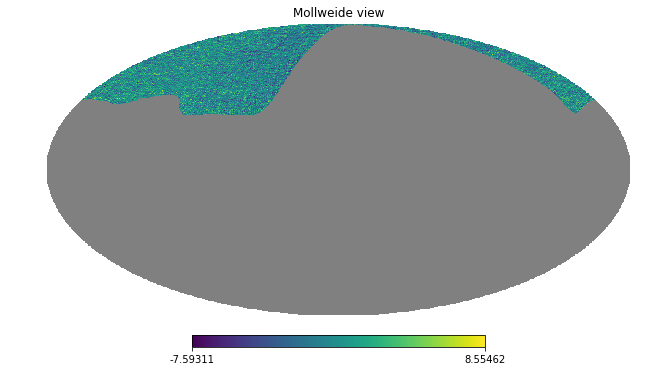

In [150]:
hp.mollview(Mask(cmb_clean[1, 1]))

In [145]:
results

   direc: array([[ 0.00000000e+00,  1.00000000e+00],
       [-7.15648132e-04,  1.09135960e-05]])
     fun: 1.9890767762058645
 message: 'Optimization terminated successfully.'
    nfev: 84
     nit: 3
  status: 0
 success: True
       x: array([-0.8748464 ,  0.02642564])

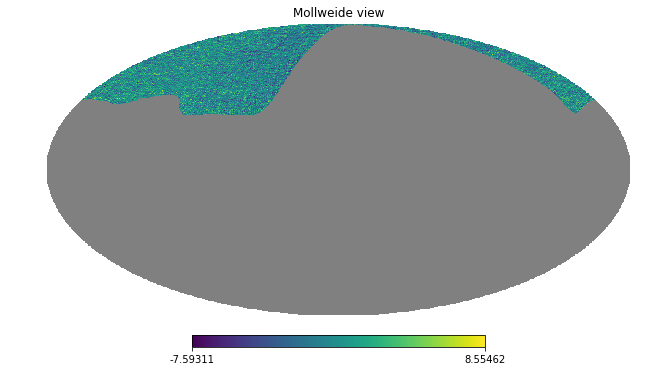

In [147]:
hp.mollview(Mask(cmb_clean[0, 1]))

<Figure size 1440x1080 with 0 Axes>

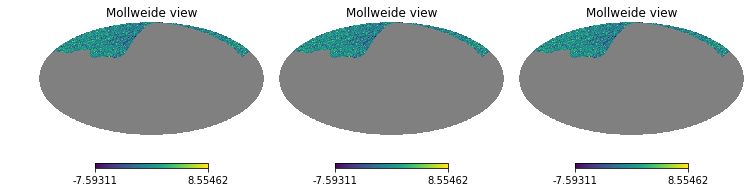

<Figure size 1440x1080 with 0 Axes>

In [143]:
hp.mollview(Mask(cmb_clean[0][1]), sub = (131)); hp.mollview(Mask(cmb_clean[1][1]), sub = (132)); hp.mollview(Mask(cmb_clean[2][1]), sub = (133))
plt.figure(figsize = (20, 15))

In [135]:
cl_95 = hp.anafast(Mask(cmb_clean[0]), lmax = lmax)
cl_150 = hp.anafast(Mask(cmb_clean[1]), lmax = lmax)
cl_353 = hp.anafast(Mask(cmb_clean[2]), lmax = lmax)

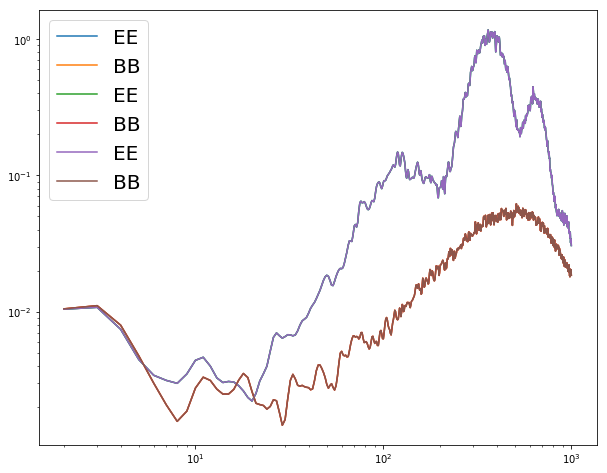

In [136]:
plot_ps(cl_95,  _nside = nside)

plot_ps(cl_150,  _nside = nside)

plot_ps(cl_353,  _nside = nside)

# plt.loglog(Ell, el2*cl_clean_95[0] , 'r-',label = 'real CMB')
# plt.loglog(Ell, el2*cl_clean_95[1] , 'r-',label = 'real CMB')

In [100]:
total_cl = hp.anafast(total_map[0])

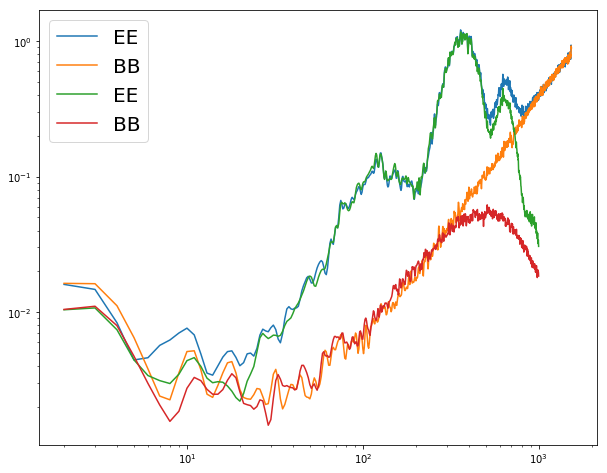

In [117]:
plot_ps(total_cl, _nside = nside)
plot_ps(cl_sevem,  _nside = nside)
